In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/Users/james/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 顯示/儲存神奇寶貝圖片

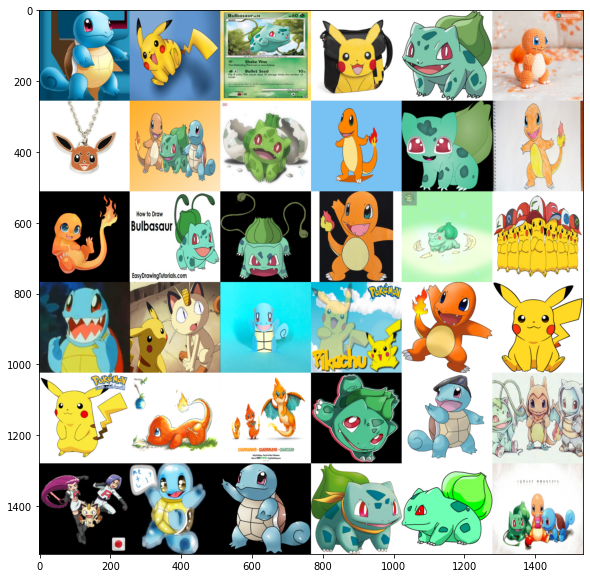

In [2]:
def show_images(images):
    grid = torchvision.utils.make_grid(images,nrow=6,padding=0)
    grid = np.array(grid)
    plt.figure(figsize=(60,10))
    plt.imshow(np.transpose(grid,(1,2,0)))

def save_images(images,IMG_SAVE_PATH):
    grid = torchvision.utils.make_grid(images,nrow=6,padding=0)
    save_image(grid,IMG_SAVE_PATH)


img_size = 256
transform = transforms.Compose([
        transforms.Resize([img_size,img_size]),
        transforms.ToTensor()
    ])

DATA_PATH = './data/datapokemon-generation-one/small_dataset'
dataset_original = torchvision.datasets.ImageFolder(root=DATA_PATH,transform=transform)
loader_original = torch.utils.data.DataLoader(dataset=dataset_original,batch_size=36,shuffle=True)
images, _ = next(iter(loader_original))
save_images(images,IMG_SAVE_PATH='./logs/pictures/original.jpg')
show_images(images)

## 設定 gpu 類型

In [3]:
def set_device():
    if torch.backends.mps.is_available():
        dev = "mps:0"
    elif torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

device = set_device()
device

device(type='mps', index=0)

## 計算 mean, std

In [4]:
def get_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=320,shuffle=True)
    mean = 0.
    std = 0.
    batch_count = 0
    for images, _ in tqdm(loader):
        #images = images.to(device)
        batch_size = images.size(0)  # batch_size = 320
        rgb_size = images.size(1)    # rgb_size = 3
        # 將第2,3維(圖片pixels的維度)合併成一個維度
        images = images.view(batch_size,rgb_size,-1) # https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
        batch_mean = images.mean([0,2]) # 將64張圖分rgb layer各自取平均值，所以會有3個數字分別對應rgb
        mean += batch_mean
        
        # 標準差的部分
        # 註一: 這裡算std只是算近似而已，詳見 http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        # 假設每個batch在算r layer的std都差不多，則可以用以下估計整體的std (g,b同理)
        # std =  sqrt [ (1 / batch_count) * sum_b std_b^2 ]
        batch_std = images.std([0,2])
        std += batch_std**2
        batch_count += 1

    mean = mean / batch_count
    std = torch.sqrt(std / batch_count)
    return mean, std

mean, std = get_mean_std(dataset_original)
print(f"mean={mean}, std={std}")


100%|██████████| 4/4 [00:24<00:00,  6.05s/it]

mean=tensor([0.6520, 0.6591, 0.5521]), std=tensor([0.3667, 0.3392, 0.3774])


## 為原始圖片做normalization,加noise,random flip,random rotate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


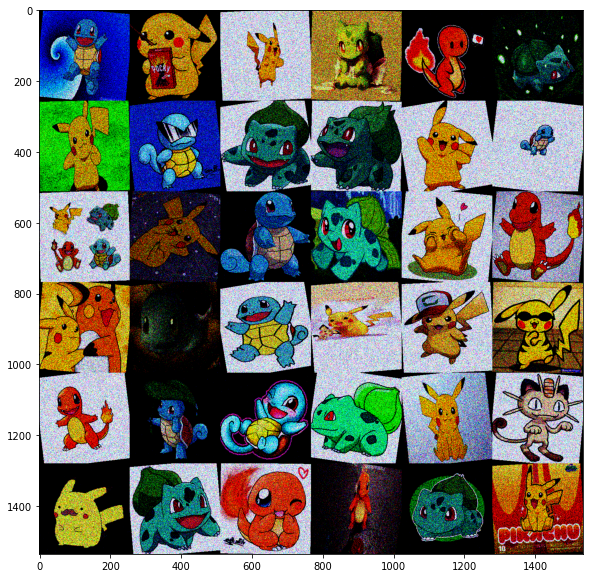

In [5]:
img_size = 256

# 為圖片加一點噪音，讓訓練出來的模型更穩定
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform = transforms.Compose([
        transforms.Resize([img_size,img_size]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
        AddGaussianNoise(mean=0.,std=.5)
    ])


DATA_PATH = './data/datapokemon-generation-one/small_dataset'
dataset_rand_transf = torchvision.datasets.ImageFolder(root=DATA_PATH,transform=transform)
loader_rand_transf = torch.utils.data.DataLoader(dataset=dataset_rand_transf,batch_size=36,shuffle=True)
images, _ = next(iter(loader_rand_transf))

show_images(images)
save_images(images,IMG_SAVE_PATH='./logs/pictures/pokemon_rand_transf.jpg')

## Autoencoder 部分

原圖片大小(batch) \
img_size = 256 \
3 * img_size * img_size = 196,608

編碼後的大小 \
latent_size = 108 * 16 * 16 = 27,648

(batch_size,3,img_size,img_size) ---> encoder ---> (batch_size,latent_size)


In [6]:
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 32, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 48, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(48, 72, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(72, 108, 5, stride=2, padding=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(108, 72, 5, stride=2, padding=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(72, 48, 5, stride=2, padding=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, 5, stride=2, padding=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2,output_padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 查看 autoencoder 每一層的輸出大小

In [7]:
from torchsummary import summary
img_size = 256
model = CNN_Autoencoder()
summary(model,(3,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           2,432
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3           [-1, 48, 64, 64]          38,448
              ReLU-4           [-1, 48, 64, 64]               0
            Conv2d-5           [-1, 72, 32, 32]          86,472
              ReLU-6           [-1, 72, 32, 32]               0
            Conv2d-7          [-1, 108, 16, 16]         194,508
   ConvTranspose2d-8           [-1, 72, 32, 32]         194,472
              ReLU-9           [-1, 72, 32, 32]               0
  ConvTranspose2d-10           [-1, 48, 64, 64]          86,448
             ReLU-11           [-1, 48, 64, 64]               0
  ConvTranspose2d-12         [-1, 32, 128, 128]          38,432
             ReLU-13         [-1, 32, 128, 128]               0
  ConvTranspose2d-14          [-1, 3, 2

### 訓練模型

In [8]:
model = CNN_Autoencoder()
model.to(device=device)
criterion = nn.MSELoss()
optimizer = torch.torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)

img_size = 256
num_epochs = 201
batch_size = 128


loader_rand_transf = torch.utils.data.DataLoader(dataset=dataset_rand_transf,batch_size=batch_size,shuffle=True)

losses  = []

with open("./logs/traing-loss.log", "a") as f:
        f.write(f'Traing New Model ...\n')

for epoch in tqdm(range(num_epochs)):

    with open("./logs/traing-loss.log", "a") as f:
        f.write(f' Epoch {epoch} ...\n')
    
    for img, _ in loader_rand_transf:
        img = img.to(device=device)
        img_recon = model(img)
        loss = criterion(img,img_recon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with open("./logs/traing-loss.log", "a") as f:
        f.write(f'  - Epoch: {epoch}, Loss:{loss.item():.4f}\n')
    losses.append(loss.item())

    if epoch % 10 == 0:
        img = torch.cat((img[:6,:,:,:],img_recon[:6,:,:,:]),dim=0).cpu()
        #show_images(img)
        save_images(img, IMG_SAVE_PATH=f'./logs/pictures/training/epoch-{epoch}.jpg')


MODEL_PATH = './models/model.pt'
torch.save(model, MODEL_PATH)


100%|██████████| 201/201 [2:31:13<00:00, 45.14s/it]  


## 檢視模型成效


可以從這裡開始執行

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===========================Autoencoder定義=====================================
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 32, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 48, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(48, 72, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(72, 108, 5, stride=2, padding=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(108, 72, 5, stride=2, padding=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(72, 48, 5, stride=2, padding=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, 5, stride=2, padding=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2,output_padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# =====================================設定gpu=====================================
def set_device():
    if torch.backends.mps.is_available():
        dev = "mps:0"
    elif torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

device = set_device()

# ================================載入已經訓練好的模型===============================
# Model class must be defined somewhere
MODEL_PATH = './models/model.pt'
model = torch.load(MODEL_PATH)
model.to(device=device)
model.eval()

# ================================資料集、資料載入器定義==============================
img_size = 256
batch_size=128
DATA_PATH = './data/datapokemon-generation-one/small_dataset'

mean = torch.tensor([0.6520, 0.6591, 0.5521])
std  = torch.tensor([0.3667, 0.3392, 0.3774])

transform = transforms.Compose([
        transforms.Resize([img_size,img_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])
dataset = torchvision.datasets.ImageFolder(root=DATA_PATH,transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)



/Users/james/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 將圖片集編碼後再進行降維，繪製2D分布圖

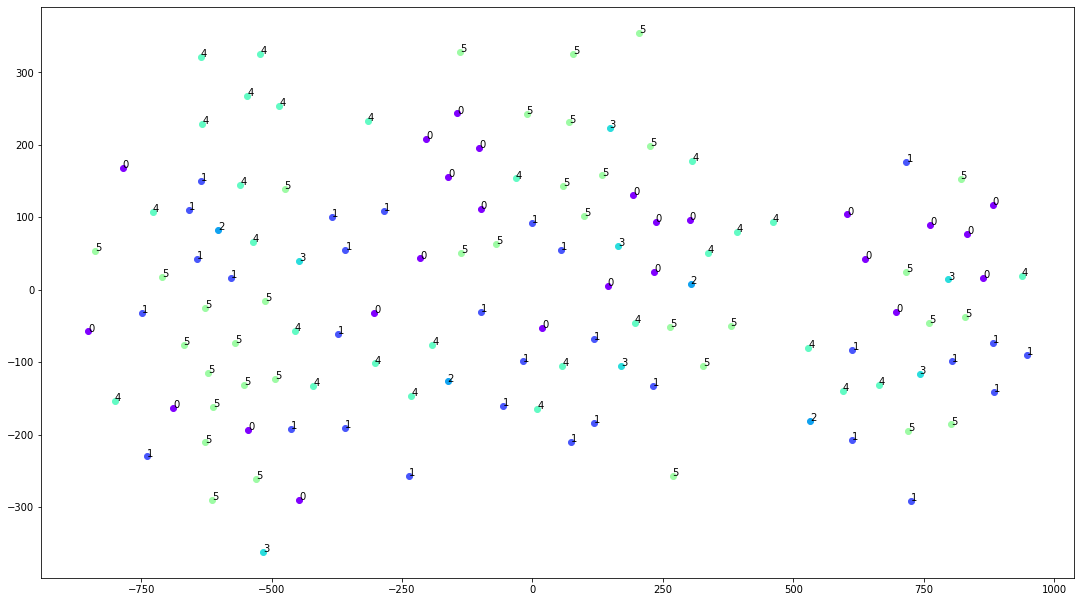

In [2]:
from sklearn import manifold
import numpy as np
import matplotlib.cm as cm

for imgs,labels in data_loader:
    imgs = imgs.to(device=set_device())
    imgs_encoded = model.encoder(imgs)
    imgs_encoded = imgs_encoded.reshape(batch_size,-1)
    imgs_encoded = imgs_encoded.cpu().detach().numpy()
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    imgs_tsne = tsne.fit_transform(imgs_encoded)
    break

x = imgs_tsne[:,0]
y = imgs_tsne[:,1]

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)

colors = cm.rainbow(np.linspace(0, 1, 10))
for i, label in enumerate(labels.tolist()):
    ax.scatter(x[i],y[i],color=colors[label])
    ax.annotate(label, (x[i],y[i]))

## 找相似的圖片

In [13]:
def random_select_image(data_loader):
    imgs, _ = next(iter(data_loader))
    imgs = imgs.to(device=device)
    img = imgs[0]
    return img

def find_top_k_similar_images(img_t, rank):
    # find the latent vector of img_t
    img_t = torch.unsqueeze(img_t,dim=0)
    #print(img_t.shape) # >>> torch.Size([1, 3, 256, 256])
    img_t_encoded = model.encoder(img_t)
    img_t_encoded = img_t_encoded.reshape(-1)
    #print(imgs_encoded.shape) # >>> torch.Size([27648])

    # find top k similar images by cosine similarity
    cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
    sim_imgs = []
    sim_imgs_score = []

    # in each batch, find top k similar images
    print('Find top k similar images ...')
    for imgs, _ in tqdm(data_loader):
        imgs = imgs.to(device=device)
        imgs_encoded = model.encoder(imgs)
        batch_size = imgs_encoded.shape[0]
        imgs_encoded = imgs_encoded.reshape(batch_size,-1)
        sim = cos_sim(img_t_encoded,imgs_encoded)
        # find the max similarity scores and the corresponding indexs in every batch
        top_sim = torch.topk(sim,k=rank)
        indices = top_sim.indices.to(device='cpu')
        imgs = imgs.to(device='cpu')
        sim_imgs += list(torch.unbind(imgs[indices,:],dim=0))
        sim_imgs_score += top_sim.values.tolist()
    
    # find top k similar images in the whole dataset
    sim_imgs_score = np.array(sim_imgs_score)
    indices = (-sim_imgs_score).argsort()[:rank]
    indices = [int(i) for i in indices]
    list_topk_imgs = [ sim_imgs[i] for i in indices]
    list_topk_imgs_score = [ sim_imgs_score[i] for i in indices]
    return list_topk_imgs, list_topk_imgs_score
    
def similar_image_process(rank=5):

    img_target = random_select_image(data_loader)
    list_topk_imgs, list_topk_imgs_score = find_top_k_similar_images(img_target, rank=rank)

    print('Similarity Scores:')
    print(list_topk_imgs_score)

    # combine top k images as an image
    tensor_topk_imgs = torch.stack(list_topk_imgs,dim=0)
    tensor_topk_grid = torchvision.utils.make_grid(tensor_topk_imgs,nrow=rank,padding=0)

    img_target = img_target.cpu().numpy()
    tensor_topk_grid = tensor_topk_grid.cpu().numpy()

    # show target image and its top k similar images
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.gca().set_title('target image')
    plt.imshow(np.transpose(img_target,(1,2,0)))

    plt.subplot(2,1,2)
    plt.gca().set_title('similar images')
    plt.imshow(np.transpose(tensor_topk_grid,(1,2,0)))


Find top k similar images ...


100%|██████████| 10/10 [00:33<00:00,  3.37s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity Scores:
[1.000000238418579, 1.000000238418579, 0.8860858082771301, 0.8808887004852295, 0.8753447532653809, 0.8722477555274963, 0.872244119644165, 0.8712238669395447, 0.8712238669395447, 0.8683783411979675]


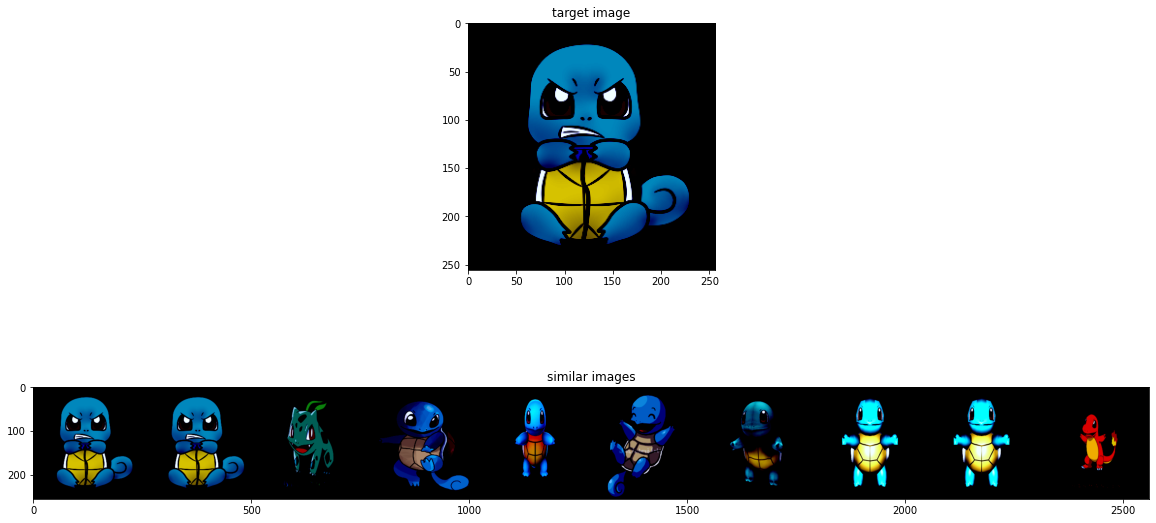

In [23]:
similar_image_process(rank=10)

Find top k similar images ...


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity Scores:
[1.0000004768371582, 0.8935562968254089, 0.8853562474250793, 0.8838552236557007, 0.8838552236557007, 0.8740396499633789, 0.8740396499633789, 0.8716397285461426, 0.8716397285461426, 0.8711930513381958]


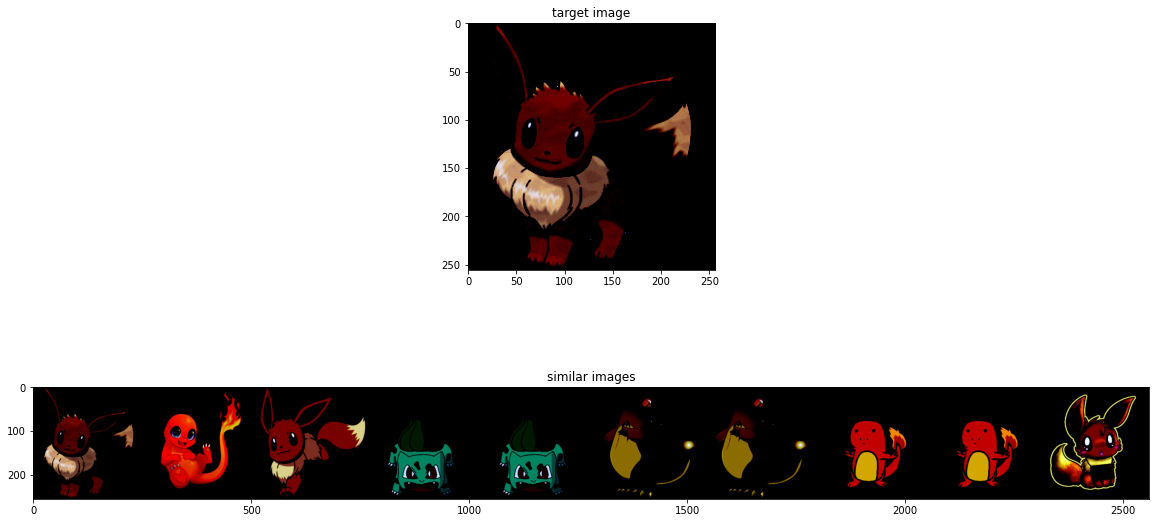

In [24]:
similar_image_process(rank=10)

Find top k similar images ...


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity Scores:
[1.0000003576278687, 1.0000003576278687, 0.8026954531669617, 0.7827317118644714, 0.7812252044677734, 0.7810704112052917, 0.7789475917816162, 0.7773193717002869, 0.7762444019317627, 0.7762444019317627]


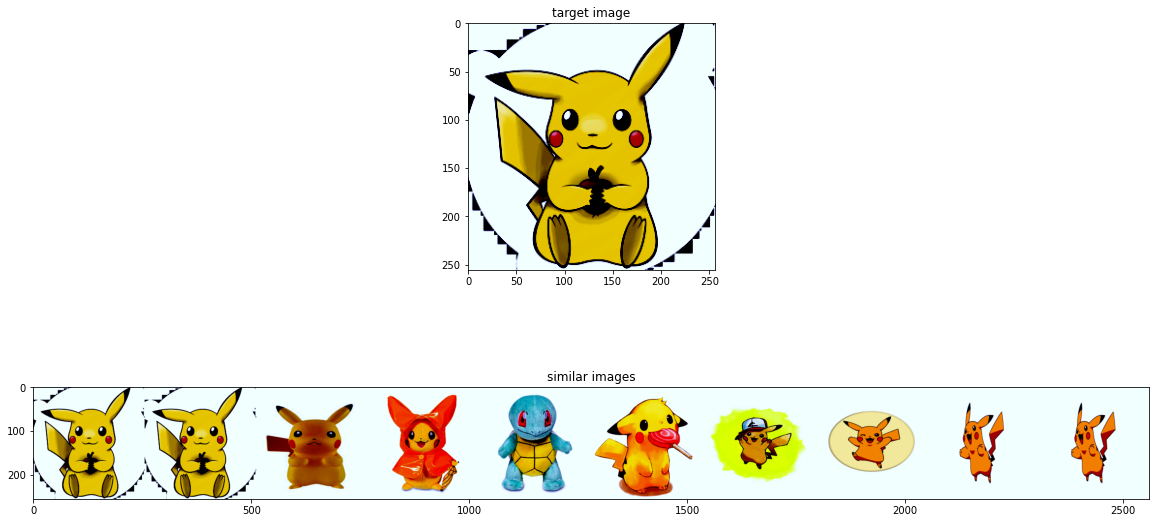

In [27]:
similar_image_process(rank=10)

Find top k similar images ...


100%|██████████| 10/10 [00:29<00:00,  2.94s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity Scores:
[1.000000238418579, 0.9305267930030823, 0.8849291801452637, 0.8825321197509766, 0.8681347370147705, 0.8598020076751709, 0.8587433099746704, 0.8571485280990601, 0.8526321649551392, 0.8387933969497681]


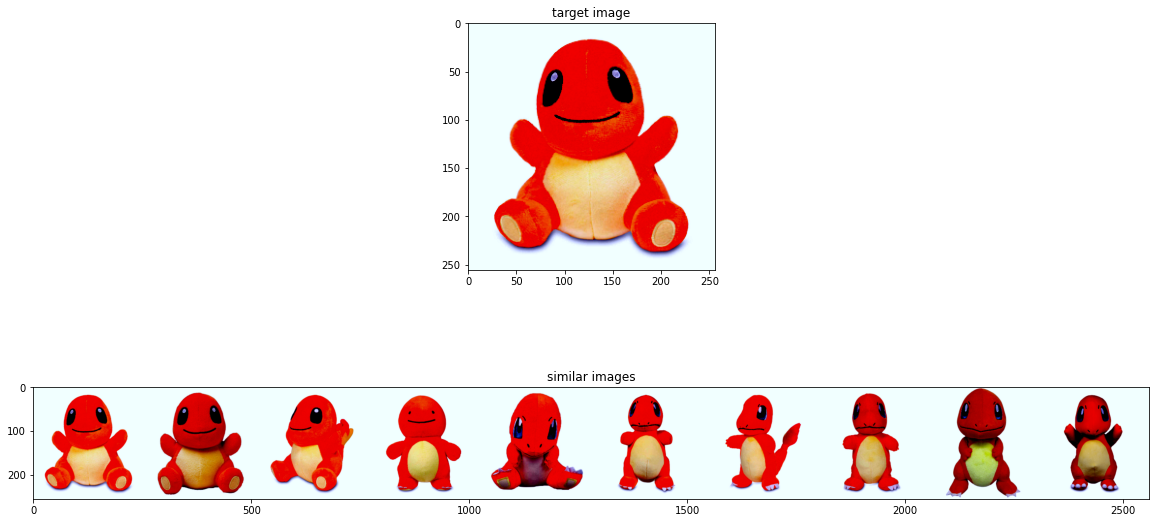

In [17]:
similar_image_process(rank=10)